In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

# Analyse Outputs
import shap

# To split the data
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

In [2]:
# It is important that your model and all data are on the same device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check that MPS is available - Added for MacOS
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

device

device(type='mps')

In [3]:
def get_data1(test_size=0.2, random_seed=42):
    '''
    returns:
    - train_data_input: Tensor[N_train_samples, C, F]
    - train_data_label: Tensor[N_train_samples, C, P]
    - test_data_input:  Tensor[N_test_samples,  C, F]
    - test_date_label:  Tensor[N_test_samples,  C, P]

    where 
     - N_train_samples = number of train/test samples
     - C = number of channels (here 1)
     - F = number of features
     - P = number of predicted features
    '''
    
    data    = pd.read_csv("../../ICPSR_IHDS-1/Simon_Personal_Aggregates/basic_features.csv")
    
    # Step 1: Replace ' ' and '' with -1
    data = data.replace([' ', ''], -1)
    # Step 2: Try to convert everything to numeric, forcing errors to NaN
    data = data.apply(pd.to_numeric, errors='coerce')
    # Step 3: Replace NaNs with -1
    data = data.fillna(-1)

    data_label = data['household_income']
    data_input = data.drop(['household_income', 'person_id'], axis=1)

    # Split data to get test and train set -> For generalization error prediction
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_label,
        test_size=test_size,
        random_state=random_seed
    )
    
    # Convert to numpy arrays
    X_train_np = X_train.to_numpy().astype(np.long)
    X_test_np = X_test.to_numpy().astype(np.long)

    y_train_np = y_train.to_numpy().astype(np.float32)
    y_test_np = y_test.to_numpy().astype(np.float32)
    
    train_y_to = torch.tensor(y_train_np, dtype=torch.float32)
    test_y_to = torch.tensor(y_test_np, dtype=torch.float32)

    # Also prepare input_dict (for models expecting dict inputs)
    X_dict_train = {col: torch.tensor(X_train[col].values, dtype=torch.long) for col in X_train.columns}
    X_dict_test  = {col: torch.tensor(X_test[col].values, dtype=torch.long)  for col in X_test.columns}

    return X_dict_train, train_y_to, X_dict_test, test_y_to
    
    # return datainp_to, datalab_to, input_dict
    
    

X_train, y_train, X_test, y_test = get_data1()
# get_data1()

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Define embedding sizes according to your "unique" numbers
        self.embeddings = nn.ModuleDict({
            'stateid': nn.Embedding(33, 8),
            'distid': nn.Embedding(61, 8),
            'distname': nn.Embedding(375, 16),
            'household_id': nn.Embedding(52, 8),
            'sex': nn.Embedding(2, 2),
            'attended_school': nn.Embedding(2, 2),
            'enrolled_or_completed': nn.Embedding(2, 2),
            'ever_repeated': nn.Embedding(2, 2),
            'englisch_ability': nn.Embedding(3, 2),
            'highest_degree': nn.Embedding(6, 4),
            'caste': nn.Embedding(8, 4),
            'hhassets': nn.Embedding(31, 8),
        })

        # Define linear layers for numerical features
        self.numerical_features = ['age', 'years_of_education', 'Ann_earnings_tot']
        
        # Final linear layer after concatenating all embeddings + numericals
        embedding_dim = (
            8 + 8 + 16 + 8 + 2 + 2 + 2 + 2 + 2 + 4 + 4 + 8  # sum of embedding dimensions
        )
        numerical_dim = len(self.numerical_features)  # 3

        total_input_dim = embedding_dim + numerical_dim

        self.fc = nn.Sequential(
            nn.Linear(total_input_dim, 32),
            nn.BatchNorm1d(32),  
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, 1) # Output: predict household_income
        )

    def forward(self, x):
        # x is expected to be a dict with keys matching the feature names
        embedded_features = []

        for key, emb_layer in self.embeddings.items():
            embedded = emb_layer(x[key])
            embedded_features.append(embedded)

        # concatenate all embeddings
        embedded_features = torch.cat(embedded_features, dim=1)

        # concatenate numerical features
        numerical_data = [x[feature].unsqueeze(1) for feature in self.numerical_features]
        numerical_data = torch.cat(numerical_data, dim=1)

        # concatenate embeddings and numerical features
        all_features = torch.cat([embedded_features, numerical_data], dim=1)

        output = self.fc(all_features)
        return output.squeeze(1)  # squeeze for regression

In [27]:
%reload_ext tensorboard
# %reload_ext tensorboard
# !rm -rf ./runs/
%tensorboard --logdir=runs --port 6006

'''
to kill process
pgrep -f tensorboard
kill -9 pid1 pid2 ...

Income
• Mean: 59659.41
• Minimum: -108327.80
• Maximum: 6520261.00
• Standard Deviation: 94614.89
'''

Reusing TensorBoard on port 6006 (pid 63132), started 0:01:32 ago. (Use '!kill 63132' to kill it.)

'\nto kill process\npgrep -f tensorboard\nkill -9 pid1 pid2 ...\n\nIncome\n• Mean: 59659.41\n• Minimum: -108327.80\n• Maximum: 6520261.00\n• Standard Deviation: 94614.89\n'

In [6]:
def train_model(input_dict_train, y_train, input_dict_test, y_test, n_epochs=10):
    writer = SummaryWriter()
    
    # --- 1. Initialize model ---
    model = Model()
    model.train()
    model.to(device)

    # --- 2. Set up training elements ---
    criterion = torch.nn.MSELoss()  # For regression
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    batch_size = 128 # Small for CPU ussage and faster convergence
    # batch_size = 100000 # Large for GPU ussage

    # --- 3. Prepare training Dataset and DataLoader ---
    input_features_train = torch.cat(
        [input_dict_train[key].unsqueeze(1) for key in input_dict_train.keys()], dim=1
    )
    dataset_train = TensorDataset(input_features_train, y_train)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

    # --- 4. Prepare test data ---
    input_features_test = torch.cat(
        [input_dict_test[key].unsqueeze(1) for key in input_dict_test.keys()], dim=1
    )
    dataset_test = TensorDataset(input_features_test, y_test)
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    # --- 5. Training loop ---
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False):
            # Split batch back into dict
            batch_input_dict = {}
            idx = 0
            for key in input_dict_train.keys():
                batch_input_dict[key] = batch_inputs[:, idx].to(device).long()
                idx += 1

            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()
            outputs = model(batch_input_dict)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        epoch_loss = epoch_loss / len(train_loader)

        # --- Evaluate on test set ---
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in tqdm(test_loader, desc=f"Testing model in Epoch {epoch}", leave=False):
                batch_input_dict = {}
                idx = 0
                for key in input_dict_test.keys():
                    batch_input_dict[key] = batch_inputs[:, idx].to(device).long()
                    idx += 1

                batch_targets = batch_targets.to(device)
                outputs = model(batch_input_dict)
                loss = criterion(outputs, batch_targets)
                test_loss += loss.item()

        test_loss = test_loss / len(test_loader)

        # --- Print training and test loss ---
        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_loss:.4f} - Test Loss: {test_loss:.4f}')
        
        # Optional: log to tensorboard
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Loss/test", test_loss, epoch)

        # Save model every 10 epochs
        if (epoch % 10 == 9):
            print("Saving current state of the model")
            torch.save(model.state_dict(), 'NN_models/model_state.pt')

    writer.close()
    return model

def load_model(PATH="NN_models/model_state.pt"):
    model = Model()

    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.to(device)
    return model

# Either train or load model that is already trained
# trained_model = train_model(X_train, y_train, X_test, y_test)
path = "NN_models/model_state_3_5_25.pt"
trained_model = load_model(PATH=path)

Metric             Loss (Rupee)      Conversion Rate      Loss (CHF)
-----------------------------------------------------------------
L1 Loss MAE          32731.9238               0.0098        320.7729
MSE Loss        6210180608.0000               0.0098   60859772.0000


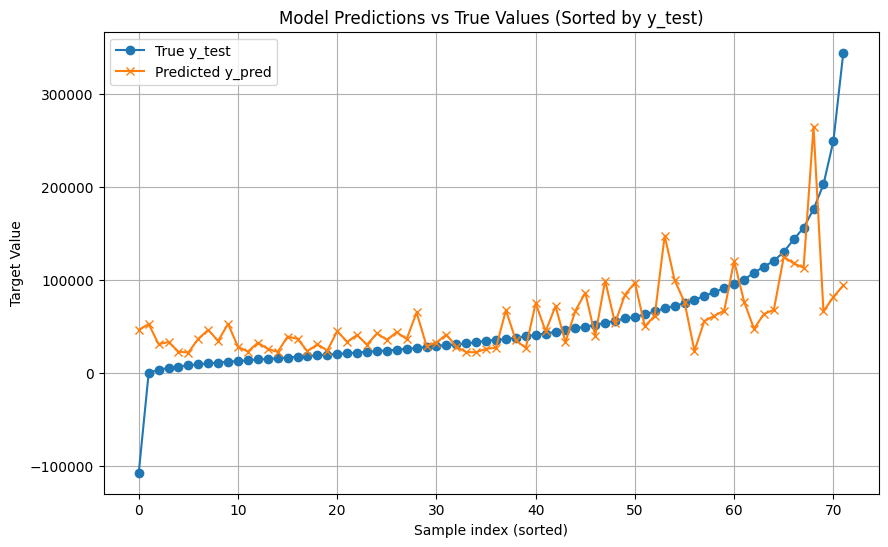

In [7]:
def test_model(X_test, y_test):
    model = trained_model
    
    X_test_device = {}
    for key in X_test.keys():
        X_test_device[key] = X_test[key].to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred = model(X_test_device)

    y_pred = y_pred.squeeze()
    y_test = y_test.clone().squeeze()

    l1loss  = torch.nn.L1Loss()
    mseloss = torch.nn.MSELoss()

    l1 = l1loss(y_pred, y_test)
    mse = mseloss(y_pred, y_test)
    rate = 0.0098
    
    print(f"{'Metric':<15} {'Loss (Rupee)':>15} {'Conversion Rate':>20} {'Loss (CHF)':>15}")
    print(f"{'-'*65}")
    print(f"{'L1 Loss MAE':<15} {l1:>15.4f} {'0.0098':>20} {(rate * l1):>15.4f}")
    print(f"{'MSE Loss':<15} {mse:>15.4f} {'0.0098':>20} {(rate * mse):>15.4f}")

    sorted_indices = torch.argsort(y_test)
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    step = 600

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_sorted.cpu().numpy()[::step], label='True y_test', marker='o')
    plt.plot(y_pred_sorted.cpu().numpy()[::step], label='Predicted y_pred', marker='x')
    plt.title('Model Predictions vs True Values (Sorted by y_test)')
    plt.xlabel('Sample index (sorted)')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.show()

test_model(X_test, y_test)

  0%|          | 0/4315 [00:00<?, ?it/s]

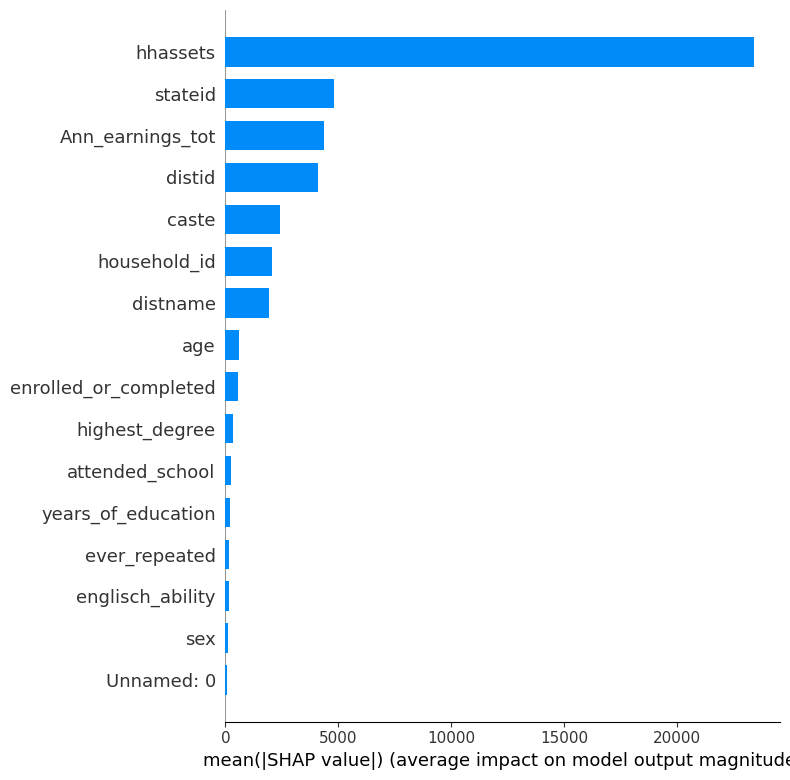

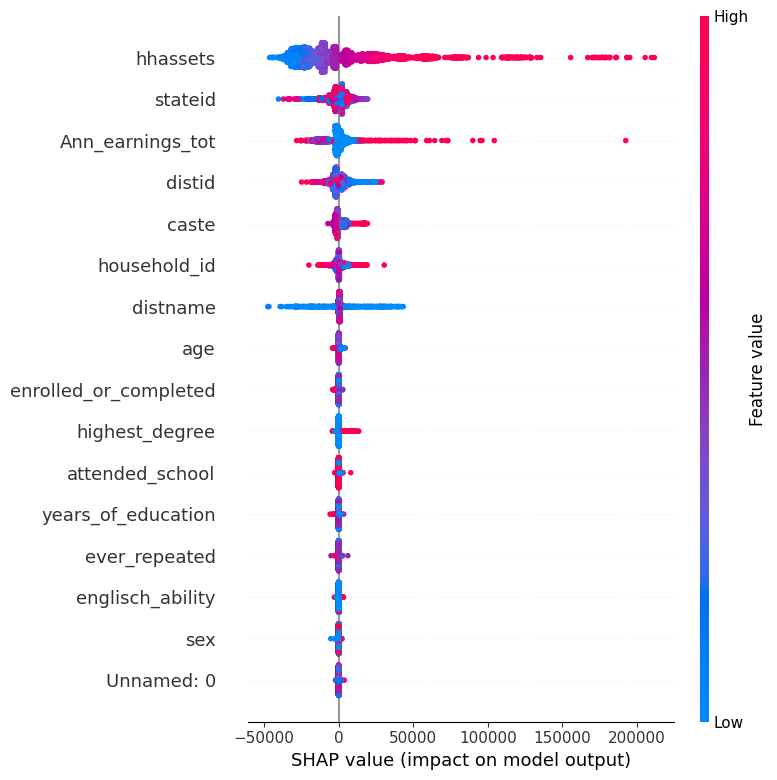

In [11]:
# SHAP - KernelExplainer
# 1. Helper to stack your dict inputs into [N, D]
def dict_to_tensor(X_dict):
    return torch.stack([X_dict[col] for col in X_dict], dim=1)

# 2. Build full tensors
X_train_tensor = dict_to_tensor(X_train)    # [N_train, D]
X_test_tensor  = dict_to_tensor(X_test)     # [N_test,  D]

# 3. Move to CPU & raw NumPy
background_full = X_train_tensor[:200].cpu().numpy()
test_array_full = X_test_tensor.cpu().numpy()

# 4. Summarize background with k-means for speed
K_bg = 30
background = shap.kmeans(background_full, K_bg).data

# 5. Subsample 10% of test set to explain
pct = 0.1
N_test = test_array_full.shape[0]
K_test = max(1, int(N_test * pct))
idx_test = np.random.choice(N_test, K_test, replace=False)
test_array = test_array_full[idx_test]

# 6. Your predict function (unchanged)
def predict_fn(np_array: np.ndarray) -> np.ndarray:
    batch = torch.tensor(np_array, dtype=torch.long, device=device)
    x_dict = {
        name: batch[:, i]
        for i, name in enumerate(X_train.keys())
    }
    with torch.no_grad():
        preds = trained_model(x_dict)
    return preds.cpu().numpy()

# 7. Create the KernelExplainer on the small background
explainer = shap.KernelExplainer(predict_fn, background)

# 8. Compute SHAP values on the test subset with fewer samples
shap_values = explainer.shap_values(test_array, nsamples=100)

# 9. Feature names
feature_names = list(X_train.keys())

# 10. Global summary plot (bar + beeswarm)
shap.summary_plot(shap_values, test_array, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values, test_array, feature_names=feature_names)

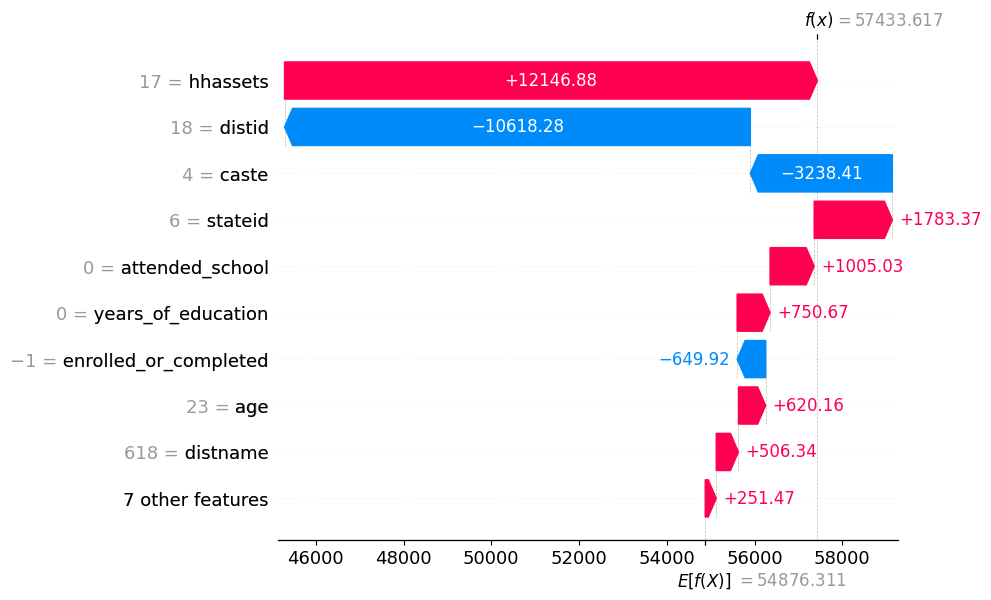

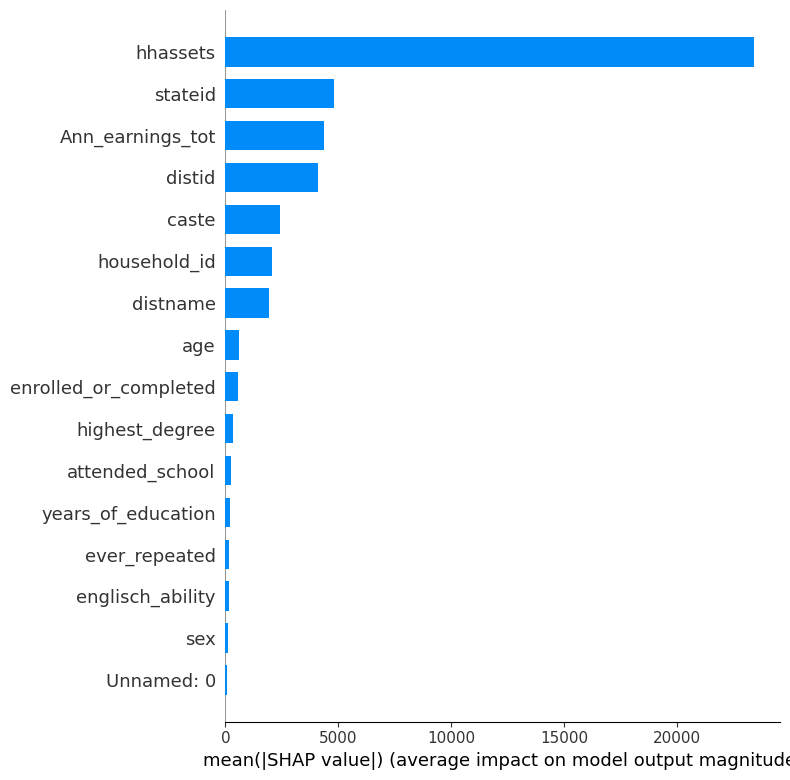

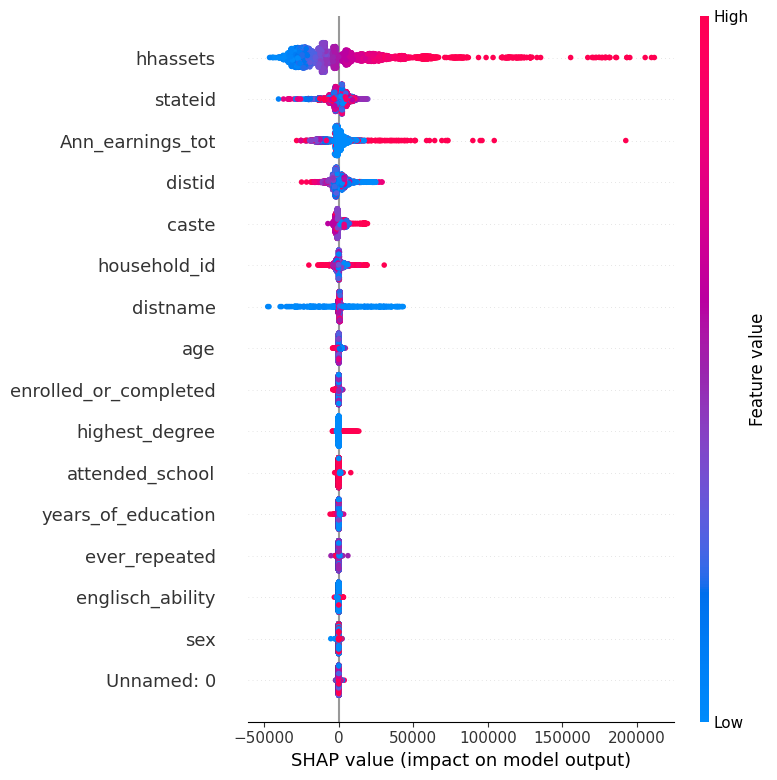

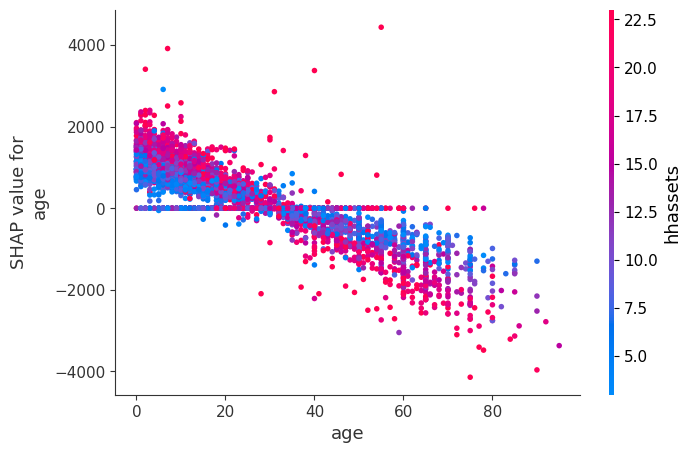

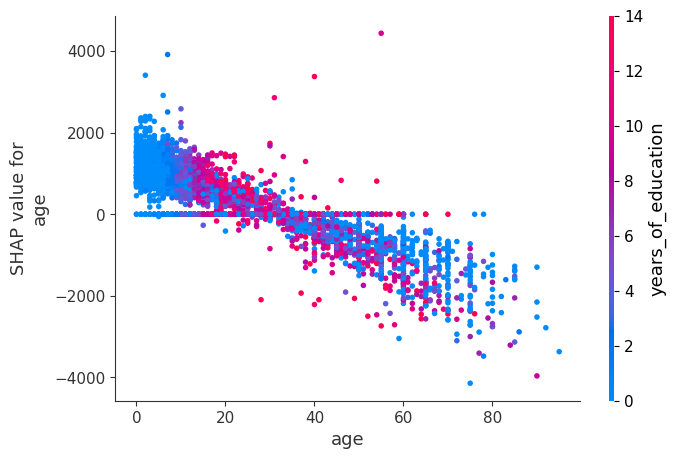

hhassets                 23374.079595
stateid                   4824.209018
Ann_earnings_tot          4339.710141
distid                    4105.736169
caste                     2402.699439
household_id              2077.534963
distname                  1915.071874
age                        607.986596
enrolled_or_completed      552.024086
highest_degree             315.733900
attended_school            239.322757
years_of_education         189.711937
ever_repeated              178.151740
englisch_ability           168.193625
sex                        115.848989
Unnamed: 0                  64.482233
dtype: float64


In [12]:
# Local explanation for first test instance
shap.initjs()

# 2) Prepare a single-row DataFrame (or just use the NumPy row + feature_names)
instance_idx = 8
row_array = test_array[instance_idx]                       # shape (D,)
row_df    = pd.DataFrame([row_array], columns=feature_names)

# 3) Draw the force plot
shap.force_plot(
    explainer.expected_value,    # scalar or length-1 list
    shap_values[instance_idx],    # shape (D,)
    row_df                        # DataFrame with 1 row
)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[instance_idx],
        base_values=explainer.expected_value,
        data=test_array[instance_idx],
        feature_names=feature_names
    )
)

shap.summary_plot(
    shap_values,
    test_array,
    feature_names=feature_names,
    plot_type="bar"
)

shap.summary_plot(
    shap_values,
    test_array,
    feature_names=feature_names
)

shap.dependence_plot(
    "age",             # feature name
    shap_values,
    test_array,
    feature_names=feature_names
)

shap.dependence_plot(
    "age",
    shap_values,
    test_array,
    feature_names=feature_names,
    interaction_index="years_of_education"
)

# mean absolute SHAP per feature
mean_abs = np.abs(shap_values).mean(axis=0)

feat_imp = pd.Series(
    mean_abs,
    index=feature_names
).sort_values(ascending=False)

print(feat_imp)